In [1]:
import time
import numpy as np
import pandas as pd

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

from pathlib import Path

### Import data

In [2]:
df_Ch001 = pd.DataFrame(pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch001.pkl")))
df_Ch009 = pd.DataFrame(pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch009.pkl")))
df_Ch020 = pd.DataFrame(pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch020.pkl")))
df_Ch022 = pd.DataFrame(pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch022.pkl")))

In [4]:
L=35
test_index = int(len(df_Ch022.index)*0.2)
X=np.vstack((df_Ch001.iloc[:,L].values, df_Ch009.iloc[:,L].values, df_Ch020.iloc[:,L].values)).T
y=df_Ch022.iloc[:,L].values

X_train=X[test_index:]
y_train=y[test_index:]

X_test=X[:test_index]
y_test=y[:test_index]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3777, 3) (3777,) (944, 3) (944,)


In [34]:
train_size = 3777
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

t0 = time.time()
svr.fit(X_train[:train_size], y_train[:train_size])
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % svr_fit)
print(svr.best_params_)

SVR complexity and bandwidth selected and model fitted in 818.802 s
{'C': 100.0, 'gamma': 0.01}


In [36]:
sv_ratio = svr.best_estimator_.support_.shape[0] / train_size
print("Support vector ratio: %.3f" % sv_ratio)

t0 = time.time()
svr=svr.best_estimator_
y_svr = svr.predict(X_test)
svr_predict = time.time() - t0
print("SVR prediction for %d inputs in %.3f s"
      % (X_test.shape[0], svr_predict))
print(mean_squared_error(y_test,y_pred))

AttributeError: 'SVR' object has no attribute 'best_estimator_'

In [37]:
y_svr = svr.predict(X_test)
svr_predict = time.time() - t0
print("SVR prediction for %d inputs in %.3f s"
      % (X_test.shape[0], svr_predict))
print(mean_squared_error(y_test,y_pred))

SVR prediction for 944 inputs in 150.059 s
0.7672982147271221


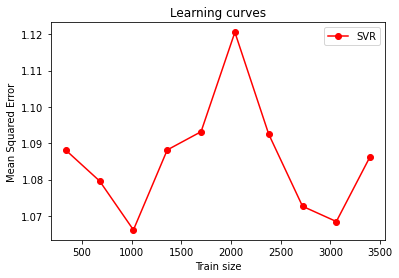

In [26]:
# Visualize learning curves
plt.figure()

svr = SVR(kernel='rbf', C=10, gamma=0.01)
train_sizes, train_scores_svr, test_scores_svr = \
    learning_curve(svr, X_train[:3777], y_train[:3777], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)

plt.plot(train_sizes, -test_scores_svr.mean(1), 'o-', color="r",
         label="SVR")

plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")

plt.show()

In [33]:
from sklearn.metrics import mean_squared_error
svr_2 = SVR(kernel='rbf', C=10, gamma=0.01)
svr_2.fit(X_train, y_train)
y_pred=svr_2.predict(X_test)
print(mean_squared_error(y_test,y_pred))

0.7672982147271221


In [102]:
X_train_1D=df_Ch020.iloc[test_index:, L].values
X_train_1D=X_train_1D.reshape((-1,1))
print(X_train_1D.shape)

(4249, 1)


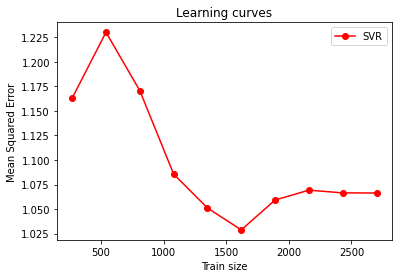

In [104]:

# Visualize learning curves
plt.figure()

svr = SVR(kernel='rbf', C=0.001, gamma=0.01)
train_sizes, train_scores_svr, test_scores_svr = \
    learning_curve(svr, X_train_1D[:3000], y_train[:3000], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)

plt.plot(train_sizes, -test_scores_svr.mean(1), 'o-', color="r",
         label="SVR")

plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")

plt.show()